# Titanic Survival Prediction – Binary Classification

This notebook demonstrates how to build several machine‑learning models to predict passenger survival on the Titanic.

**Models covered**:

* Logistic Regression  
* Decision Tree  
* Random Forest  
* XGBoost  
* Multi‑Layer Perceptron (Neural Network)


In [1]:
# Core packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit‑learn utilities
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             confusion_matrix, ConfusionMatrixDisplay,
                             RocCurveDisplay)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Ignore warnings for cleaner output
import warnings, sys, os
warnings.filterwarnings('ignore')

## Load the dataset

In [3]:
# Update the path if your CSV is elsewhere
DATA_PATH = '/content/Titanic-Dataset.csv'
df = pd.read_csv(DATA_PATH)
print(df.head())
print("\nMissing values per column:")
print(df.isna().sum())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  

M

## Data preprocessing

In [4]:
# 1. Basic cleaning / new features
df['FamilySize'] = df['SibSp'] + df['Parch']
df['HasCabin'] = df['Cabin'].notna().astype(int)

# Fill missing Age with median, Embarked with mode
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Columns to drop (IDs & mostly unique strings)
drop_cols = ['Name', 'Ticket', 'Cabin', 'PassengerId']
df = df.drop(columns=drop_cols)

# Separate X and y
X = df.drop('Survived', axis=1)
y = df['Survived']

# Categorical & numeric features
categorical = ['Sex', 'Embarked', 'Pclass']
numeric     = [col for col in X.columns if col not in categorical]

# Column transformer: one‑hot encode categoricals, scale numerics for NN
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical),
    ('num', 'passthrough', numeric)
])

# For tree models we won't scale; for logistic reg./MLP we’ll add scaling when needed.

## Train / test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (712, 9) Test shape: (179, 9)


## Logistic Regression

In [6]:
log_reg = Pipeline(steps=[
    ('prep', preprocess),
    ('scale', StandardScaler(with_mean=False)),  # sparse after OHE
    ('model', LogisticRegression(max_iter=1000))
])
log_reg.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Sex', 'Embarked',
                                                   'Pclass']),
                                                 ('num', 'passthrough',
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare', 'FamilySize',
                                                   'HasCabin'])])),
                ('scale', StandardScaler(with_mean=False)),
                ('model', LogisticRegression(max_iter=1000))])

## Decision Tree

In [7]:
tree = Pipeline(steps=[
    ('prep', preprocess),
    ('model', DecisionTreeClassifier(random_state=42))
])
tree.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Sex', 'Embarked',
                                                   'Pclass']),
                                                 ('num', 'passthrough',
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare', 'FamilySize',
                                                   'HasCabin'])])),
                ('model', DecisionTreeClassifier(random_state=42))])

## Random Forest

In [8]:
rf = Pipeline(steps=[
    ('prep', preprocess),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Sex', 'Embarked',
                                                   'Pclass']),
                                                 ('num', 'passthrough',
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare', 'FamilySize',
                                                   'HasCabin'])])),
                ('model', RandomForestClassifier(random_state=42))])

## XGBoost

In [9]:
xgb = Pipeline(steps=[
    ('prep', preprocess),
    ('model', XGBClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, objective='binary:logistic',
        eval_metric='logloss', random_state=42, use_label_encoder=False
    ))
])
xgb.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Sex', 'Embarked',
                                                   'Pclass']),
                                                 ('num', 'passthrough',
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare', 'FamilySize',
                                                   'HasCabin'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

## Neural Network (MLP)

In [10]:
# Build preprocessing + scaling pipeline
from sklearn.pipeline import make_pipeline

mlp_preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical),
    ('num', StandardScaler(), numeric)
])

X_train_nn = mlp_preprocess.fit_transform(X_train)
X_test_nn  = mlp_preprocess.transform(X_test)

model_mlp = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

history = model_mlp.fit(X_train_nn, y_train, epochs=100, batch_size=32,
                        validation_split=0.2, callbacks=[early_stop], verbose=0)

## Evaluate models

In [11]:
def evaluate(model, X_data, y_true, model_name, nn=False):
    if nn:
        proba = model.predict(X_data).ravel()
        preds = (proba >= 0.5).astype(int)
    else:
        proba = model.predict_proba(X_data)[:, 1]
        preds = (proba >= 0.5).astype(int)
    acc  = accuracy_score(y_true, preds)
    f1   = f1_score(y_true, preds)
    auc  = roc_auc_score(y_true, proba)
    return {'Model': model_name, 'Accuracy': acc, 'F1': f1, 'AUC': auc, 'Proba': proba, 'Preds': preds}

results = []
results.append(evaluate(log_reg, X_test, y_test, 'Logistic Regression'))
results.append(evaluate(tree,    X_test, y_test, 'Decision Tree'))
results.append(evaluate(rf,      X_test, y_test, 'Random Forest'))
results.append(evaluate(xgb,     X_test, y_test, 'XGBoost'))
results.append(evaluate(model_mlp, X_test_nn, y_test, 'MLP', nn=True))

metrics_df = pd.DataFrame(results).drop(columns=['Proba', 'Preds'])
display(metrics_df)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


,Model,Accuracy,F1,AUC
0,Logistic Regression,0.810056,0.738462,0.838999
1,Decision Tree,0.759777,0.686131,0.750329
2,Random Forest,0.787709,0.724638,0.830237
3,XGBoost,0.787709,0.703125,0.814756
4,MLP,0.787709,0.703125,0.831225


### Confusion matrices

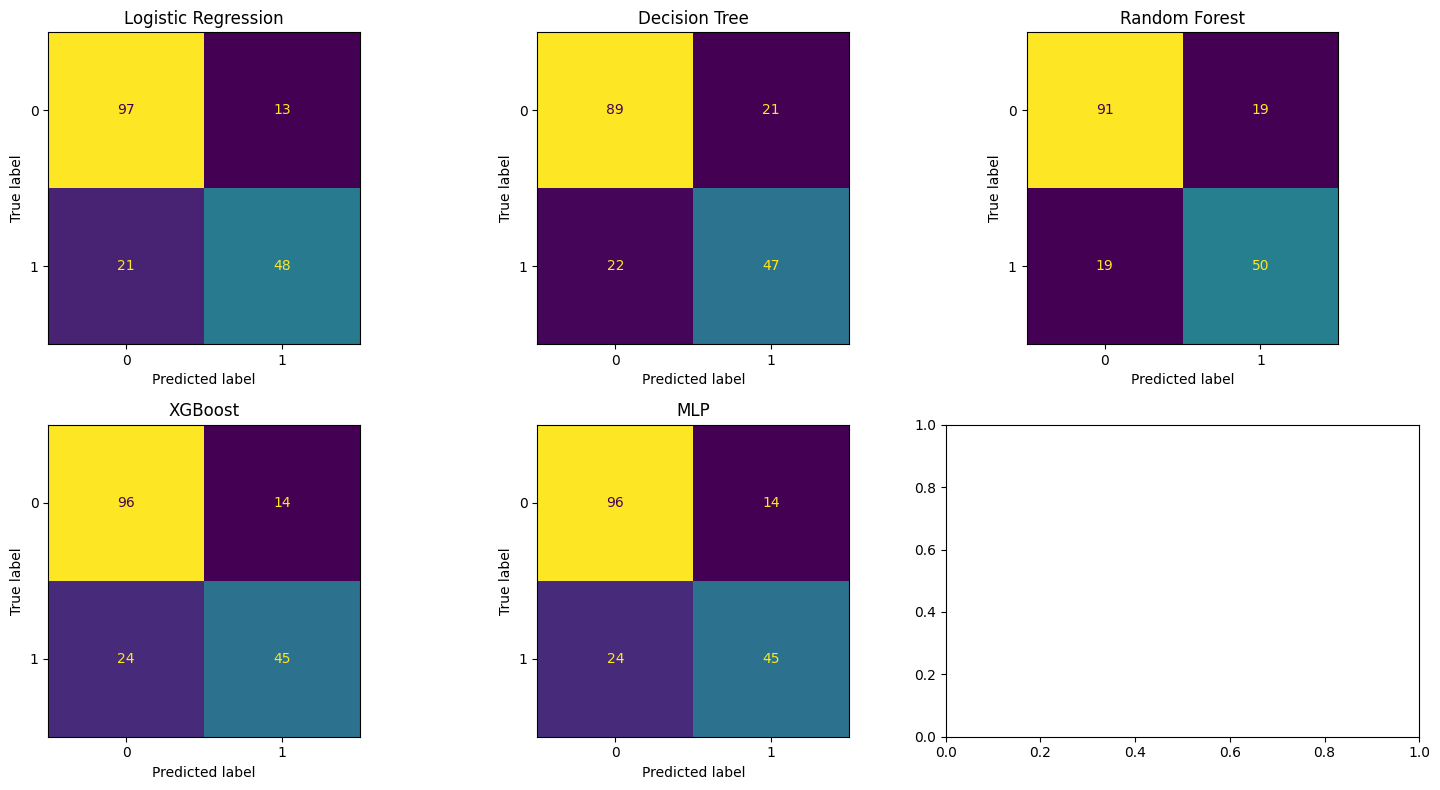

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for ax, res in zip(axes, results):
    cm = confusion_matrix(y_test, res['Preds'])
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(res['Model'])

plt.tight_layout()
plt.show()

### ROC curves

<Figure size 800x600 with 0 Axes>

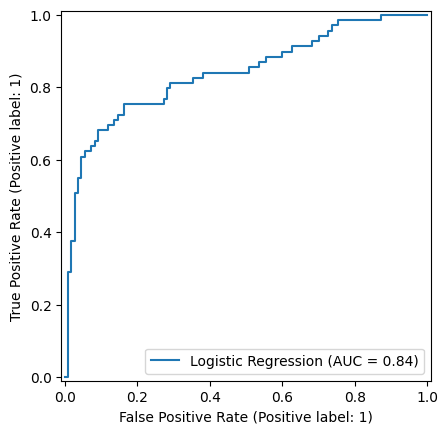

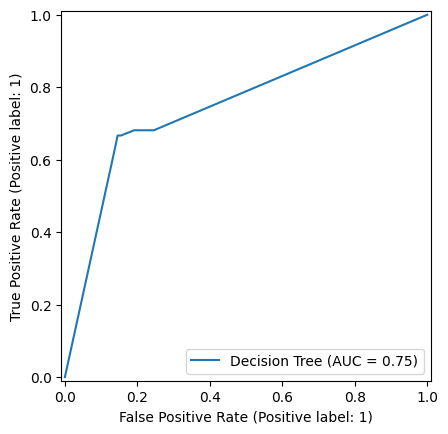

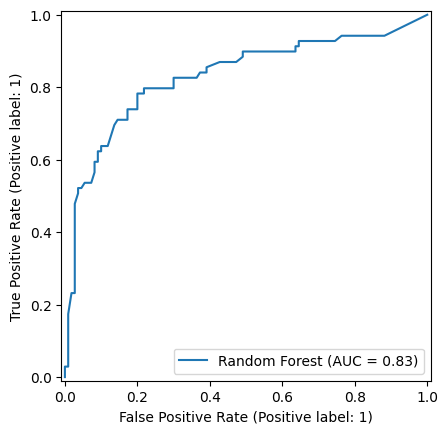

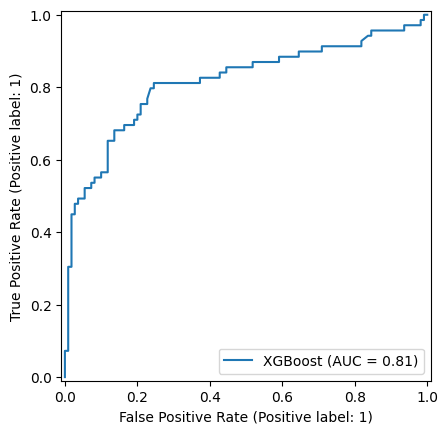

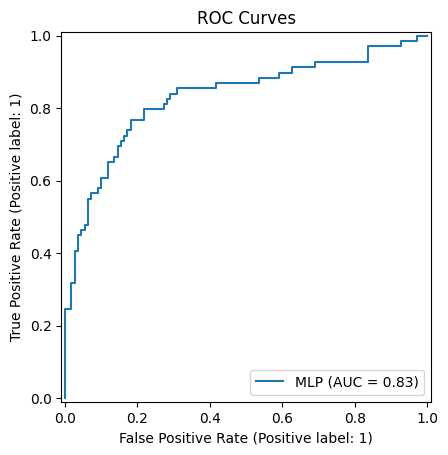

In [13]:
plt.figure(figsize=(8, 6))
for res in results:
    RocCurveDisplay.from_predictions(y_test, res['Proba'],
                                     name=res['Model'], plot_chance_level=False)
plt.title('ROC Curves')
plt.show()

### Feature importance (Random Forest)

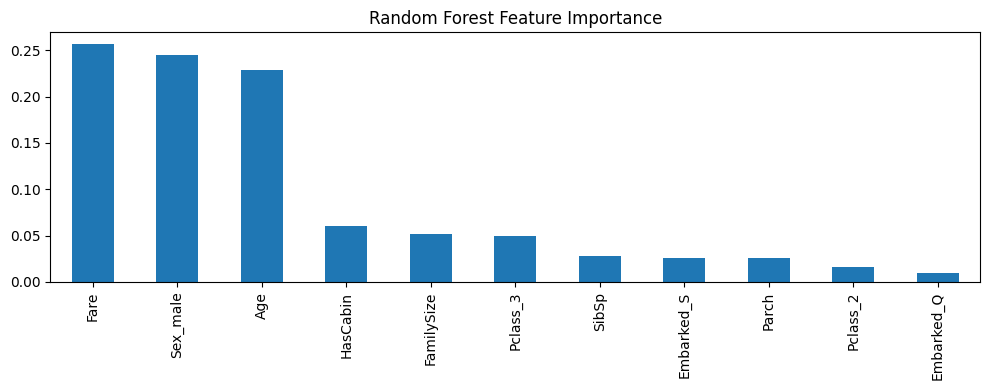

In [14]:
# Get feature names after preprocessing
ohe = log_reg.named_steps['prep'].named_transformers_['cat']
cat_features = ohe.get_feature_names_out(['Sex', 'Embarked', 'Pclass'])
feature_names = list(cat_features) + numeric

importances = rf.named_steps['model'].feature_importances_

fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
fi.plot(kind='bar', figsize=(10,4), title='Random Forest Feature Importance')
plt.tight_layout()
plt.show()